In [659]:
# Basics
import pandas as pd
import numpy as np
import os
import geopy

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px

# Regression Models
from sklearn.linear_model import LinearRegression, Ridge, LassoCV, RidgeCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Pipeline 
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 

# Split
from sklearn.model_selection import train_test_split

# Baseline
from sklearn.metrics import mean_absolute_error
# Tunning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
pd.set_option('display.max_columns', None)

In [6]:
#           ### CONCAT FILES IN CSVs FOLDER ###

# files = [file_path for file_path in os.listdir('Seasons Data/Spring') if file_path.endswith('.csv')]

# df = pd.read_csv(os.path.join('Seasons Data/Spring', files[0]))

# for csv_path in files[1:]:
#     df_to_add = pd.read_csv(os.path.join('Seasons Data/Spring', csv_path))
#     df = pd.concat([df,df_to_add])
    
    
# #df.reset_index(drop=True, inplace=True)

# df.to_csv('Spring_Data.csv')

In [1928]:
COLS = ['review_scores_accuracy','review_scores_location','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
        'neighbourhood_cleansed','picture_url','description','has_availability','host_since','host_response_time','host_is_superhost', 'host_listings_count',
        'host_has_profile_pic', 'host_identity_verified', 'latitude','longitude', 'room_type', 'accommodates','bathrooms_text', 'bedrooms', 'beds', 'amenities',
        'price','minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_reviews_l30d',
        'review_scores_rating', 'instant_bookable','reviews_per_month']

def wrangle_data(PATH):
    df = pd.read_csv(PATH, usecols=COLS, low_memory=False)
    
    df = df[df['has_availability'] == 't']
    
#     df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str).apply(lambda x: x.replace('%','') if x!='nan' else np.nan)
#     df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(float)/100
    
    df['host_since'] = pd.to_datetime(df['host_since']).dt.year
    
    # Bool Columns
    df['host_is_superhost'] = [True if i == 't' else False if i == 'f' else np.nan for i in df['host_is_superhost']]
    df['host_has_profile_pic'] = [True if i == 't' else False if i == 'f' else np.nan for i in df['host_has_profile_pic']]
    df['host_identity_verified'] = [True if i == 't' else False if i == 'f' else np.nan for i in df['host_identity_verified']]
    df['instant_bookable'] = [True if i == 't' else False if i == 'f' else np.nan for i in df['instant_bookable']]
    
    
    df['description_len'] = df['description'].astype(str).apply(lambda x: len(x) if x!='nan' else np.nan)
    
    df['n_amenities'] = df['amenities'].apply(lambda x: len(x.strip('][').split(', ')) if len(x)>2 else np.nan)

    df['n_bathrooms'] = [np.nan if i=='nan' else
                         0.5 if i.split()[0]=='Half-bath' else
                         1.0 if i.split()[0] in ['Private','Shared'] else
                         float(i.split()[0]) for i in df['bathrooms_text'].astype(str)]
    
    df['price'] = df['price'].apply(lambda x: x.replace('$','').replace(',',''))
    df['price'] = df['price'].astype(float)
    
    # Engineer Features
    df['baths_are_shared'] = [np.nan if i=='nan' else True if i.count('shared')!=0 else False for i in df['bathrooms_text'].astype(str)]
    
    df['multi_listing_host'] = [np.nan if i==np.nan else True if i>1 else False for i in df['host_listings_count']]
    
    df['total_satisfaction'] = (df['review_scores_accuracy']+df['review_scores_cleanliness']+df['review_scores_checkin']+df['review_scores_communication']+df['review_scores_location'])/5
    
    df.drop(columns=['has_availability','description', 'amenities','bathrooms_text', 'host_listings_count',
                     'review_scores_accuracy','review_scores_location','review_scores_cleanliness',
                     'review_scores_checkin','review_scores_communication'], inplace=True)
    
    
    
    # Rename Columns
    df.columns = ['picture_url', 'host_since', 'response_time', 'superhost',
       'host_profile_pic', 'id_verified', 'neighbourhood_cleansed', 'lat',
       'lon', 'room_type', 'accommodates', 'n_bedrooms', 'n_beds', 'price',
       'min_nights', 'max_nights', 'total_reviews',
       'n_reviews_l30d', 'reviews_rating', 'instant_bookable',
       'reviews_per_month', 'description_len', 'n_amenities', 'n_baths',
       'shared_baths', 'multi_listing_host', 'total_satisfaction']
    
    # Reorder Columns
    df = df[['neighbourhood_cleansed','lat', 'lon','host_since','room_type','response_time','picture_url','host_profile_pic','id_verified','superhost','instant_bookable',
             'multi_listing_host','description_len','n_amenities','accommodates','n_bedrooms','n_beds','n_baths','shared_baths','min_nights', 'max_nights','n_reviews_l30d',
             'reviews_per_month','total_reviews','total_satisfaction','reviews_rating','price']]
    
    #Filtering Outliers From
    # price Column
    df = df[(df['price'] >= df['price'].quantile(0.1)) & (df['price'] <= df['price'].quantile(0.90))]
    # min_nights Column
    df = df[(df['min_nights'] >= df['min_nights'].quantile(0.01)) & (df['min_nights'] <= df['min_nights'].quantile(0.99))]
    # max_nights Column
    df = df[(df['max_nights'] >= df['max_nights'].quantile(0.001)) & (df['max_nights'] <= df['max_nights'].quantile(0.99))]
    # n_amenities Column
    df = df[(df['n_amenities'] >= df['n_amenities'].quantile(0.005)) & (df['n_amenities'] <= df['n_amenities'].quantile(0.999))]
    # n_baths Column
    df = df[(df['n_baths'] >= df['n_baths'].quantile(0.0001)) & (df['n_baths'] <= df['n_baths'].quantile(0.9999))]
    # n_beds Column
    df = df[(df['n_beds'] >= df['n_beds'].quantile(0.01)) & (df['n_beds'] <= df['n_beds'].quantile(0.99))]
    # description_len Column
    df = df[(df['description_len'] >= df['description_len'].quantile(0.01)) & (df['description_len'] <= df['description_len'].quantile(0.99))]
#     # reviews_per_month Column
    df = df[df['reviews_per_month'] <= df['reviews_per_month'].quantile(0.99)]

    
    
    # Null Values
    df['response_time'][df['response_time'].isnull()] = 'within an hour'
    df = df[df['host_profile_pic'].notnull() & df['superhost'].notnull() & df['id_verified'].notnull()]
    
    
    #df['zip_state'] = [i[:3] for i in df['neighbourhood_cleansed']]
    #df['zip_region'] = [i[-2:] for i in df['neighbourhood_cleansed']]
    
    # #Scale Columns
    # df['log_reviews_per_month'] = [np.nan if i==np.nan else 0 if i==0 else np.log(i) for i in df['reviews_per_month']]
    # df['log_total_reviews'] = [np.nan if i==np.nan else 0 if i==0 else np.log(i) for i in df['total_reviews']]
    
    df['host_experience_yrs'] = round(2021 - df['host_since'])
    #df['reviews_per_month'] = round(df['total_reviews']/(df['host_experience_yrs']*12),2)
    #Drop Highly Correlated Features & last min drops
    df.drop(columns=['n_reviews_l30d', 'picture_url', 'reviews_rating','host_profile_pic','host_since','response_time','id_verified','multi_listing_host','neighbourhood_cleansed'], inplace=True)
    df.dropna(inplace=True)
    
    df['ppl_per_bed'] = [a/n if n!=0 else a/1 for a,n in zip(df['accommodates'],df['n_beds'])]
    
    df['superhost'] = df['superhost'].astype(bool)
    df['shared_baths'] = df['shared_baths'].astype(bool)
    #df['id_verified'] = df['id_verified'].astype(bool)
    
    df = df[(df['total_reviews']>40) & (df['reviews_per_month']>0.35)]
    
    return df

In [1929]:
Winter_df = wrangle_data('Concat_CSVs/Winter_Data.csv')
Spring_df = wrangle_data('Concat_CSVs/Spring_Data.csv')
Summer_df = wrangle_data('Concat_CSVs/Summer_Data.csv')
Fall_df = wrangle_data('Concat_CSVs/Fall_Data.csv')

In [1930]:
print('Spring mean price:', '$'+str(round(Spring_df['price'].mean())))
print('Summer mean price:', '$'+str(round(Summer_df['price'].mean())))
print('Fall mean price:', '$'+str(round(Fall_df['price'].mean())))
print('Winter mean price:', '$'+str(round(Winter_df['price'].mean())))

Spring mean price: $136
Summer mean price: $151
Fall mean price: $157
Winter mean price: $161


In [1931]:
print('Spring Data shape:', Spring_df.shape)
print('Summer Data shape:', Summer_df.shape)
print('Fall Data shape:', Fall_df.shape)
print('Winter Data shape:', Winter_df.shape)

Spring Data shape: (33703, 20)
Summer Data shape: (36077, 20)
Fall Data shape: (38396, 20)
Winter Data shape: (39806, 20)


In [1932]:
Spring_df.head()

,lat,lon,room_type,superhost,instant_bookable,description_len,n_amenities,accommodates,n_bedrooms,n_beds,n_baths,shared_baths,min_nights,max_nights,reviews_per_month,total_reviews,total_satisfaction,price,host_experience_yrs,ppl_per_bed
7,37.83234,-122.25101,Entire home/apt,False,False,1000.0,33.0,5,3.0,3.0,1.5,False,30,365,0.99,125,9.2,198.0,11.0,1.666667
12,37.84211,-122.25203,Entire home/apt,True,False,1000.0,22.0,2,1.0,1.0,1.0,False,3,60,1.90,229,10.0,151.0,10.0,2.000000
16,37.84419,-122.23405,Entire home/apt,True,True,1000.0,28.0,4,2.0,4.0,1.5,False,3,10,2.29,271,10.0,160.0,10.0,1.000000
17,37.77847,-122.17615,Entire home/apt,False,False,1000.0,34.0,2,1.0,1.0,1.0,False,2,365,1.65,193,9.8,99.0,10.0,2.000000
18,37.80732,-122.24293,Private room,True,False,1000.0,33.0,2,1.0,1.0,1.0,False,2,120,2.35,271,9.8,69.0,10.0,2.000000


In [1933]:

# geolocator = geopy.Nominatim(user_agent='myusername')

# def get_zipcode(df, geolocator, lat_field, lon_field):
#     location = geolocator.reverse((df[lat_field], df[lon_field]))
#     return location.raw['address']['postcode']

# zipcodes = Spring_df[['lat','lon']].head(2).apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='lat', lon_field='lon')

# zipcodes

In [1934]:
Spring_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33703 entries, 7 to 192709
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lat                  33703 non-null  float64
 1   lon                  33703 non-null  float64
 2   room_type            33703 non-null  object 
 3   superhost            33703 non-null  bool   
 4   instant_bookable     33703 non-null  bool   
 5   description_len      33703 non-null  float64
 6   n_amenities          33703 non-null  float64
 7   accommodates         33703 non-null  int64  
 8   n_bedrooms           33703 non-null  float64
 9   n_beds               33703 non-null  float64
 10  n_baths              33703 non-null  float64
 11  shared_baths         33703 non-null  bool   
 12  min_nights           33703 non-null  int64  
 13  max_nights           33703 non-null  int64  
 14  reviews_per_month    33703 non-null  float64
 15  total_reviews        33703 non-null

In [1935]:
Spring_df.describe()

,lat,lon,description_len,n_amenities,accommodates,n_bedrooms,n_beds,n_baths,min_nights,max_nights,reviews_per_month,total_reviews,total_satisfaction,price,host_experience_yrs,ppl_per_bed
count,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000,33703.000000
mean,35.729955,-105.275130,901.328250,31.468801,3.956413,1.549120,2.071774,1.267632,7.923034,567.316648,2.562091,115.933062,9.833433,136.077233,6.184731,2.044687
std,6.778708,24.810508,201.218852,8.807944,2.198228,0.819044,1.295668,0.538665,12.207482,520.043700,1.452175,80.930837,0.269354,72.480563,2.267259,0.735833
min,18.982690,-159.711430,85.000000,6.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.360000,41.000000,7.800000,50.000000,0.000000,0.142857
25%,32.744400,-122.026185,941.000000,26.000000,2.000000,1.000000,1.000000,1.000000,1.000000,30.000000,1.450000,59.000000,9.800000,82.000000,5.000000,1.666667
50%,36.964450,-115.186600,1000.000000,31.000000,4.000000,1.000000,2.000000,1.000000,2.000000,365.000000,2.250000,89.000000,10.000000,116.000000,6.000000,2.000000
75%,40.713730,-80.180365,1000.000000,37.000000,5.000000,2.000000,3.000000,1.500000,4.000000,1125.000000,3.350000,144.000000,10.000000,170.000000,8.000000,2.000000
max,47.733320,-70.997010,1000.000000,67.000000,16.000000,9.000000,7.000000,10.000000,91.000000,1125.000000,7.500000,839.000000,10.000000,395.000000,13.000000,12.000000


# **Select Target ( X,y = FM,TV )**

In [1936]:
X_Spring = Spring_df.drop(columns=['price'])
y_Spring = Spring_df['price']

X_Summer = Summer_df.drop(columns=['price'])
y_Summer = Summer_df['price']

X_Fall = Fall_df.drop(columns=['price'])
y_Fall = Fall_df['price']

X_Winter = Winter_df.drop(columns=['price'])
y_Winter = Winter_df['price']

Text(0.5, 1.0, 'Features Correlation Spring Data')

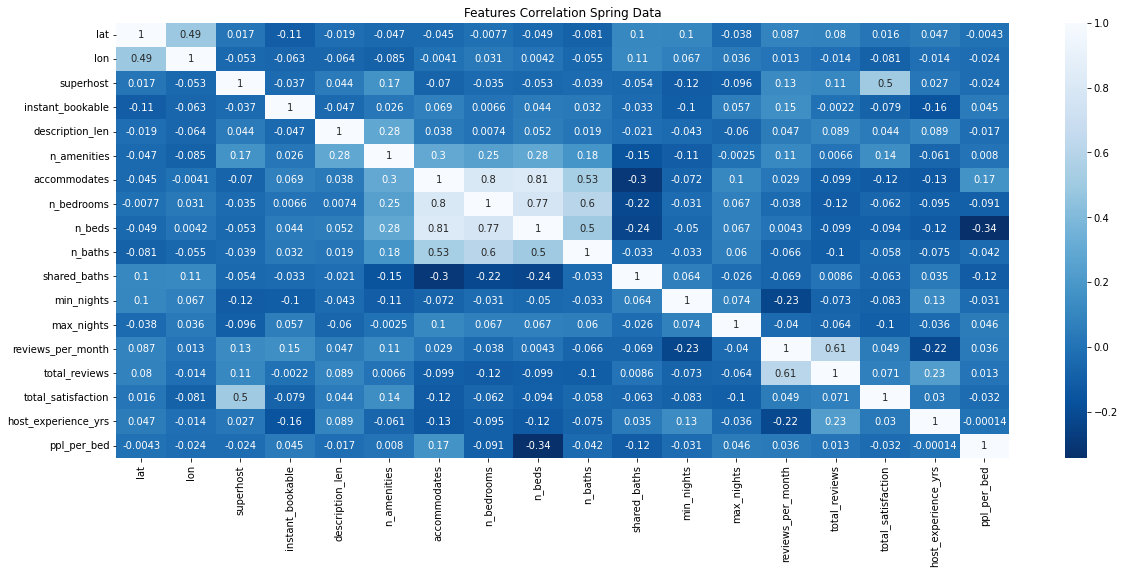

In [1937]:
plt.figure(figsize=(20,8))
sns.heatmap(X_Spring.corr(), annot=True, cmap="Blues_r")
plt.title('Features Correlation Spring Data')

Text(0.5, 1.0, 'Scaled Feature (reviews_per_month) Spring Data')

<Figure size 1440x576 with 0 Axes>

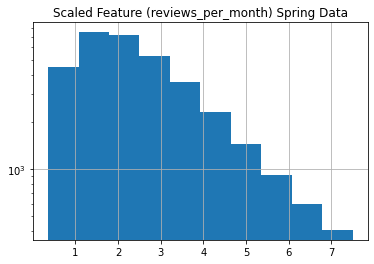

In [1938]:
plt.figure(figsize=(20,8))
Spring_df.hist('reviews_per_month', log = True)  #(X.corr(), annot=True, cmap="Blues_r")
plt.title('Scaled Feature (reviews_per_month) Spring Data')

Text(0.5, 1.0, 'Scaled Feature (total_reviews) Spring Data')

<Figure size 1440x576 with 0 Axes>

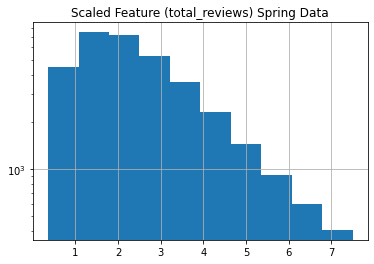

In [1939]:
plt.figure(figsize=(20,8))
Spring_df.hist('reviews_per_month', log = True)  #(X.corr(), annot=True, cmap="Blues_r")
plt.title('Scaled Feature (total_reviews) Spring Data')

# **Split Data**

In [1940]:
# X_train1, X_test1, y_train1, y_test1 = train_test_split(X_Spring, y_Spring, test_size=0.20, random_state=42) # Spring Data
# X_train2, X_test2, y_train2, y_test2 = train_test_split(X_Summer, y_Summer, test_size=0.20, random_state=42) # Summer Data
# X_train3, X_test3, y_train3, y_test3 = train_test_split(X_Fall, y_Fall, test_size=0.20, random_state=42)     # Fall Data
# X_train4, X_test4, y_train4, y_test4 = train_test_split(X_Winter, y_Winter, test_size=0.20, random_state=42) # Winter Data

In [1941]:
# X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

# **SET BASELINE**

In [1942]:
y_pred1 = [y_Spring.mean()] * len(y_Spring)
y_pred2 = [y_Summer.mean()] * len(y_Summer)
y_pred3 = [y_Fall.mean()] * len(y_Fall)
y_pred4 = [y_Winter.mean()] * len(y_Winter)

print('Spring Data Baseline (MAE): ',mean_absolute_error(y_Spring,y_pred1))
print('Summer Data Baseline (MAE): ',mean_absolute_error(y_Summer,y_pred2))
print('Fall Data Baseline (MAE): ',mean_absolute_error(y_Fall,y_pred3))
print('Winter Data Baseline (MAE): ',mean_absolute_error(y_Winter,y_pred4))

Spring Data Baseline (MAE):  56.37218930339543
Summer Data Baseline (MAE):  63.586171669638645
Fall Data Baseline (MAE):  64.96574865487659
Winter Data Baseline (MAE):  68.05825007302096


# **Models Pipeline**

In [1943]:
model_rfr1 = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(n_jobs=-1, random_state=42))

model_rfr2 = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(n_jobs=-1, random_state=42))

model_rfr3 = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(n_jobs=-1, random_state=42))

model_rfr4 = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(n_jobs=-1, random_state=42))

# **Fitting Models**

In [1944]:
#model_rfr1.fit(X_train1,y_train1);
# model_rfr2.fit(X_train2,y_train2);
# model_rfr3.fit(X_train3,y_train3);
# model_rfr4.fit(X_train4,y_train4);

# **Checking and Comparing Metrics**

In [1945]:
# def check_metrics(model_list, model_names, X_train_list, X_test_list, y_train_list, y_test_list):
#   # print each model results
#     for model, name, X_train, X_test, y_train, y_test in zip(model_list, model_names, X_train_list, X_test_list, y_train_list, y_test_list):
#       print(name)
#       print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
#       print('Test MAE:', mean_absolute_error(y_test, model.predict(X_test)))
#       print('Test R^2:', model.score(X_test, y_test))
#       print()
#       print()

# models = [model_rfr1,model_rfr2,model_rfr3,model_rfr4]
# models_names = ['RandomForestRegressor Spring:','RandomForestRegressor Summer:','RandomForestRegressor Fall:','RandomForestRegressor Winter:']
# X_train_data = [X_train1, X_train2, X_train3, X_train4] 
# y_train_data = [y_train1, y_train2, y_train3, y_train4] 
# X_test_data = [X_test1, X_test2, X_test3, X_test4]
# y_test_data = [y_test1, y_test2, y_test3, y_test4]


# check_metrics(models, models_names, X_train_data, X_test_data, y_train_data, y_test_data)

In [1946]:
# importance_df['abs'] = [abs(i) for i in importance_df[0]]
# importance_df.sort_values(by='abs',ascending=False).head(10)

In [1947]:
# y_pred_train = model_la.predict(X_train_processed)
# diff = y_train - y_pred_train
# plt.figure(figsize=(14,10))
# plt.scatter(np.arange(len(diff)),diff);

In [1948]:
# def check_metrics(model):
#   #print(model)
#   print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
#   print('Test MAE:', mean_absolute_error(y_test, model.predict(X_test)))
#   print('Test R^2:', model.score(X_test, y_test))
#   print()
#   print()

# models = [model_lr, model_rd, model_rfr, model_xgb]
# models_name = ['LinearRegression:','Ridge:','RandomForestRegressor','XGBRegressor:']
# for i in range(4):
#   print(models_name[i])
#   check_metrics(models[i])
    
# LinearRegression:
# Training MAE: 75.11048377427583
# Test MAE: 74.0995566954852
# Test R^2: 0.43788657500640593


# Ridge:
# Training MAE: 75.1104311013773
# Test MAE: 74.09950469620095
# Test R^2: 0.4378865254712687


# RandomForestRegressor
# Training MAE: 19.63839671554341
# Test MAE: 52.93756419855532
# Test R^2: 0.6586319303160858


# XGBRegressor:
# Training MAE: 51.04689117492001
# Test MAE: 55.166844811515766
# Test R^2: 0.6447322467459573

In [1949]:
# # Lists to Plot Models
# models = [model_lr, model_rd, model_rfr, model_xgb]
# models_type = ['Linear', 'Ridge', 'RForest', 'XGB']
# Training_MAEs = []
# Test_MAEs = []
# models_R2s = []

# def listing_metrics(model):
#   # Fill lists to plot and compare models
#   Training_MAEs.append(mean_absolute_error(y_train, model.predict(X_train)))
#   Test_MAEs.append(mean_absolute_error(y_test, model.predict(X_test)))
#   models_R2s.append(model.score(X_test, y_test))

# for m in models:
#   listing_metrics(m)

In [1950]:
# # Plot Models MAEs
# w = 0.4
# bar1 = np.arange(len(models_type))
# bar2 = [i + w for i in bar1]


# plt.figure(figsize=(9,5.5))
# plt.bar(bar1, Training_MAEs, w, label='Training MAE')
# plt.bar(bar2, Test_MAEs, w, label='Test MAE')

# plt.xlabel('Models')
# plt.ylabel('Mean Absolute Error')
# plt.xticks(bar1+(w/2), models_type)
# plt.legend()
# plt.title('Models MAE (Train-Test Data)')

# plt.show()

In [1951]:
# # Plot Models R^2s
# w = 0.4
# bar1 = np.arange(len(models_type))

# plt.figure(figsize=(5,5.5))
# plt.bar(bar1, models_R2s, w, label='R^2')

# plt.xlabel('Models')
# plt.ylabel('R-Square Values')
# plt.xticks(bar1, models_type)
# plt.legend()
# plt.title('Models R2 (Test-Data)')

# plt.show()

# **Tunning Random Forest Regressor**

In [1952]:
%%time
param_grid = {"randomforestregressor__n_estimators": range(105,106),
              "randomforestregressor__min_samples_split": range(2,3),
              "randomforestregressor__min_samples_leaf": [1],
              "randomforestregressor__max_samples":  [None],
              "randomforestregressor__max_features":['log2'],
              "randomforestregressor__max_depth": [None],#range(27,32),  
              "randomforestregressor__bootstrap": [True]
              
             }


model_rfr_search1 = GridSearchCV(model_rfr, param_grid= param_grid, cv=10, verbose=1)
model_rfr_search2 = GridSearchCV(model_rfr, param_grid= param_grid, cv=10, verbose=1)
model_rfr_search3 = GridSearchCV(model_rfr, param_grid= param_grid, cv=10, verbose=1)
model_rfr_search4 = GridSearchCV(model_rfr, param_grid= param_grid, cv=10, verbose=1)

# Fit it to the data
model_rfr_search1.fit(X_Spring, y_Spring);
model_rfr_search2.fit(X_Summer, y_Summer);
model_rfr_search3.fit(X_Fall, y_Fall);
model_rfr_search4.fit(X_Winter, y_Winter);

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
CPU times: total: 2min 34s
Wall time: 2min 6s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['room_type'])),
                                       ('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             param_grid={'randomforestregressor__bootstrap': [True],
                         'randomforestregressor__max_depth': [None],
                         'randomforestregressor__max_features': ['log2'],
                         'randomforestregressor__max_samples': [None],
                         'randomforestregressor__min_samples_leaf': [1],
                         'randomforestregressor__min_samples_

In [1953]:
#model_rfr_search.best_params_

In [1960]:
models = [model_rfr_search1, model_rfr_search2, model_rfr_search3, model_rfr_search4]
models_names = ['ModelSpring','ModelSummer','ModelFall','ModelWinter']

check_metrics(models, models_names, X_train_data, X_test_data, y_train_data, y_test_data)

# print('Test MAE:', mean_absolute_error(y_test1, model_rfr_search1.predict(X_test1)))
# print('Test R^2:', model_rfr_search.score(X_test1,y_test1))


ModelSpring
Training MAE: 12.946564300373362
Test MAE: 12.814512000715828
Test R^2: 0.9393268866860071


ModelSummer
Training MAE: 14.354514616583154
Test MAE: 14.020025824446556
Test R^2: 0.941747919906727


ModelFall
Training MAE: 14.661181391426215
Test MAE: 14.618241980820105
Test R^2: 0.9405215682554102


ModelWinter
Training MAE: 14.928769417577358
Test MAE: 15.345949410493494
Test R^2: 0.9401690129643316




In [1955]:
# importances = model_rfr_search.best_estimator_.named_steps.randomforestregressor.feature_importances_
# features = model_rfr_search.best_estimator_.named_steps.onehotencoder.feature_names

# imp_df = pd.DataFrame(importances, index=features)
# imp_df.columns = ['Importances']

# imp_df.sort_values(by='Importances', ascending=False).head(50)

In [1962]:
# save the models
import pickle

for model,name in zip(models, models_names):
    
    pickle.dump(model, open(name+'.pkl', "wb"))

# # load the models
# model = pickle.load(open("model.pkl", "rb"))

# # use model to predict
# y_pred = model.predict(X_input)

In [1956]:
# param_grid = {"ridge__alpha": [1000,100,50,20,10,1,0.1,0.01],
#               "ridge__fit_intercept": [True,False]
#              }

# model_rd_search = GridSearchCV(
#     model_rd,
#     param_grid = param_grid,
#     cv=5,
#     verbose=1# status updates
# )

# # Fit it to the data
# model_rd_search.fit(X, y);

In [1957]:
# model_rd_search.best_params_

In [1958]:
# check_metrics(model_rd_search)

# print('Test MAE:', mean_absolute_error(y_test, model_rd_search.predict(X_test)))
# print('Test R^2:', model_rd_search.score(X_test,y_test))